# **Speech Emotion Recognition Using Machine Learning**
- Anusha Das

This project focusses on identifying emotions elicited by a person while talking. I have built three classification models based on deep neural networks(CNN), Multilayer Perceptron(MLP), and Support Vector Machine(SVM). The models have been trained to classify 8 different emotions(neutral, calm, happy, sad, angry, fear, disgust, surprised) using the Ryerson Audio-Visual Database of Emotional Speech and Song(RAVDESS) dataset.

## **Performance Metrics Chosen**
We need a metric that compares discrete classes in some way because classification models produce discrete output. Classification Metrics assess a model's performance and tell you whether the classification is good or bad, but each one does so in a unique way.
- Accuracy

Accuracy is the simplest metric to use and implement and is defined as the number of correct predictions divided by the total number of predictions, multiplied by 100. It would simply tell us how many labels our model got right.

- Confusion Matrix
  
Confusion Matrix is a tabular visualization of the ground-truth labels versus model predictions. Each row of the confusion matrix represents the instances in a predicted class and each column represents the instances in an actual class. Confusion Matrix is not exactly a performance metric but sort of a basis on which other metrics evaluate the results.
This metric will help in analyzing labels that the model is getting mixed up in.

- Precision

Precision is the ratio of true positives and total positives predicted. A precision score towards 1 will signify that the model didn’t miss any true positives, and is able to classify well between correct and incorrect labeling. So, Precision will tell out of all the predicted labels, which ones are _actually_ true.

- Recall

Recall is essentially the ratio of true positives to all the positives in ground truth. It serves as the opposite of precision, so it will tell us, for example, out all the 'happy' audio files how many were predicted as 'happy' by our model.

- F1 Score

The F1-score metric is the harmonic mean of precision and recall. Since the dataset is slightly imbalanced, it presents a good balance between precision and recall.



**Importing Libraries**

In [1]:
import glob
import os
import time
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# **About the dataset**

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes neutral, calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [2]:
# Data Preprocessing

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading audio file
x, sr = librosa.load('/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_01//03-01-01-01-01-01-01.wav')

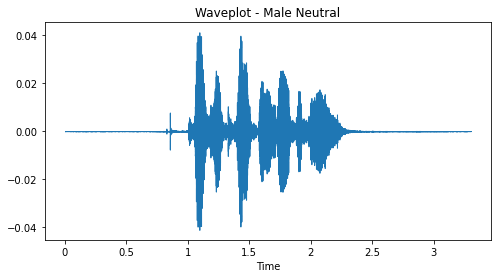

In [5]:
# waveplot display
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Waveplot_MaleNeutral.png')

In [6]:
# Audio in reference
import soundfile as sf
sf.write('MaleNeutral.wav', np.random.randn(10, 2), 44100, 'PCM_24')
Audio(data=x, rate=sr)

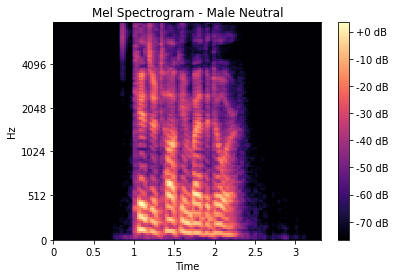

In [7]:
# creating Log Mel Spectogram
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB');

The Mel spectrogram is used to provide our models with sound information similar to what a human would perceive.

In [8]:
# Labeling Audio Files

In [9]:
# Creating directory
audio = "/content/drive/My Drive/Audio_Speech_Actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders = ['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [10]:
# Creating function for extracting emotion, number, actor, and gender labels
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [11]:
# Looking at the data
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df

,gender,emotion,actor,path
0,male,calm,1,/content/drive/My Drive/Audio_Speech_Actors_01...
1,male,neutral,1,/content/drive/My Drive/Audio_Speech_Actors_01...
2,male,calm,1,/content/drive/My Drive/Audio_Speech_Actors_01...
3,male,calm,1,/content/drive/My Drive/Audio_Speech_Actors_01...
4,male,neutral,1,/content/drive/My Drive/Audio_Speech_Actors_01...
...,...,...,...,...
1435,female,surprise,24,/content/drive/My Drive/Audio_Speech_Actors_01...
1436,female,surprise,24,/content/drive/My Drive/Audio_Speech_Actors_01...
1437,female,surprise,24,/content/drive/My Drive/Audio_Speech_Actors_01...
1438,female,surprise,24,/content/drive/My Drive/Audio_Speech_Actors_01...


In [12]:
# Shuffling the data
pd.set_option('display.max_colwidth', -1)

audio_df.sample(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,gender,emotion,actor,path
652,male,fear,11,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_11/03-01-06-02-02-02-11.wav
207,female,angry,4,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_04/03-01-05-01-01-01-04.wav
21,male,happy,1,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_01/03-01-03-01-02-02-01.wav
721,male,neutral,13,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_13/03-01-01-01-02-02-13.wav
10,male,happy,1,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_01/03-01-03-01-01-01-01.wav
839,female,surprise,14,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_14/03-01-08-02-02-01-14.wav
642,male,disgust,11,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_11/03-01-07-02-01-01-11.wav
1184,female,fear,20,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_20/03-01-06-02-01-02-20.wav
616,male,happy,11,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_11/03-01-03-02-01-01-11.wav
1275,female,calm,22,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_22/03-01-02-01-02-01-22.wav


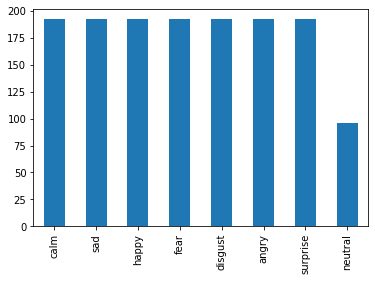

In [13]:
# Distribution of classes
audio_df.emotion.value_counts().plot(kind='bar')

In [14]:
# Saving the file
audio_df.to_csv('/content/drive/My Drive/audio.csv')

### Feature Extraction

In [15]:
# Extracting Log mel Spectogram means for modelling
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram 
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

1440


,mel_spectrogram
0,"[-78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.43884, -78.4542, -78.4542, -78.4542, -78.41042, -78.45068, -78.4542, -78.42379, -78.20893, -78.26179, -78.393005, -78.181946, -76.54556, -77.80522, -78.35667, -78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.35812, -78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.4542, -78.30332, -77.40237, -76.72194, -74.78916, -73.5713, -71.05219, -71.32608, -74.50437, -51.601734, -40.75338, -37.786884, -35.510395, -33.946377, -33.06304, -32.153732, -30.557005, -30.412754, -31.12473, -31.028309, -31.162865, -31.399376, -31.185083, -32.001812, -32.653805, -33.62147, -33.717075, -33.821217, -34.81197, -35.28008, -36.12838, -37.141144, -38.139374, -39.70676, -43.652508, -47.02291, -49.263157, -49.088577, -44.685097, -41.291615, -40.862713, -42.37775, -43.935345, -42.301487, -39.064354, -37.1027, -36.956676, -37.50367, -38.67591, -39.754787, -39.825855, -40.14709, -40.670406, -40.860516, -41.18104, -42.499855, -42.641098, -43.528965, -43.827126, -42.342186, -38.96177, -40.174595, -41.470406, -38.25139, -34.112953, -32.843117, ...]"
1,"[-75.15071, -75.15071, -75.15071, -75.15071, -75.15071, -75.15071, -75.15071, -75.13959, -75.07223, -75.15071, -75.15071, -75.15071, -75.15071, -75.09937, -75.15071, -75.15071, -75.15071, -75.10905, -75.09412, -75.15071, -74.92822, -74.1517, -74.19842, -74.51549, -75.11954, -75.10399, -75.13165, -75.15071, -75.15071, -75.14988, -75.15071, -75.15071, -75.15071, -75.15071, -75.15071, -75.069016, -74.12102, -73.617714, -74.536026, -74.17392, -73.56244, -72.48515, -73.084854, -49.680855, -39.80159, -36.830807, -35.70478, -34.180237, -31.86353, -30.69315, -30.325382, -30.965012, -30.82406, -30.03375, -28.690538, -28.168774, -28.138542, -29.081398, -30.787271, -33.000286, -37.51421, -41.930313, -44.93863, -44.383247, -41.121105, -40.154667, -39.98905, -39.938183, -41.252926, -40.4535, -37.338863, -35.710594, -36.26966, -36.070953, -36.352516, -36.936497, -38.03057, -39.899944, -40.525482, -41.244236, -41.383785, -40.33425, -38.542667, -39.557934, -40.667435, -37.19942, -32.58196, -32.73895, -33.5526, -37.302288, -43.403584, -39.877724, -35.744804, -34.76521, -34.00362, -33.99902, -34.42435, -35.477673, -38.351665, -41.04027, ...]"
2,"[-76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.65121, -76.677536, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.80453, -76.5322, -76.44933, -76.64952, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.82804, -76.568886, -74.67807, -73.09236, -74.03147, -74.68943, -64.24568, -47.49774, -41.946453, -39.79607, -39.147137, -40.741, -42.837166, -43.604366, -42.124516, -37.26098, -35.17254, -34.234646, -34.051994, -33.869507, -32.931118, -32.81923, -34.01837, -36.192253, -41.01848, -45.500793, -46.88576, -48.46097, -48.98278, -49.02873, -48.43186, -48.262344, -47.850143, -45.676563, -43.822456, -43.251183, -42.20799, -42.379887, -43.17235, -42.853916, -43.618324, -44.138092, -44.0167, -44.09061, -44.682087, -45.904766, -46.873642, -47.451687, -47.429253, -50.21714, -54.75737, -57.29435, -58.95968, -59.25489, -61.76557, -57.759243, -42.46049, -38.936752, -42.34256, -43.494522, -43.32022, -41.76798, -41.904247, -43.785294, ...]"
3,"[-83.15074, -83.15074, -83.15074, -83.15074, -83.15074, -83.15074, -83.15074, -83.13651, -83.108086, -83.15074, -83.15074, -83.14127, -82.37242, -82.121544, -81.68829, -80.64291, -81.102776, -80.855865, -81.77177, -82.979225, -82.591644, -82.88915, -83.06165, -83.07818, -83.15074, -83.0173, -82.86421, -82.346596, -80.91314, -80.11132, -81.33677, -81.87924, -82.3181, -82.660355, -82.50171, -82.17024, -80.8913, -78.14449, -74.36539, -74.15344, -75.37415, -73.597206, -66.10196, -47.972996, -43.003082, -43.90949, -45.47786, -45.996483, -46.930073, -47.1809, -42.50079

In [16]:
# Turning array into list to combine with Audio_df to get emotion labels of each audio file
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [17]:
# Dropping path column
df_combined.drop(columns='path',inplace=True)

In [18]:
# Looking at the data
df_combined.head()

,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,calm,1,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.438843,-78.454201,...,-78.155396,-78.425537,-78.454201,-78.454201,-78.454201,-78.441124,-78.454201,0.000000,0.000000,0.000000
1,male,neutral,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,calm,1,-76.828041,-76.828041,-76.828041,-76.828041,-76.828041,-76.828041,-76.651207,...,-76.828041,-76.828041,-76.828041,-76.828041,-76.828041,-76.828041,-76.828041,-76.828041,-76.805473,-76.828041
3,male,calm,1,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,...,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742
4,male,neutral,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 1D-CNN (without Data Augmentation)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Splitting data into training and testing sets
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion','gender','actor']])

In [21]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 259)


In [22]:
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(288, 259)


In [23]:
# Data normalization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [24]:
# Transforming data into arrays 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [25]:
# Implementing One-hot encoding 
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [29]:
# Reshaping data 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_train.shape

(1152, 259, 1, 1)

### Initial Model - Without Data Augmentation

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

# Building 1D CNN Layers
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 250, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 241, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 21, 128)           163968    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 128)           0         
 1D)                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
import tensorflow.keras as keras

# Model fitting and saving best model
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/40
36/36 [==============================] - ETA: 0s - loss: 2.4918 - accuracy: 0.2318
Epoch 1: val_accuracy improved from -inf to 0.29861, saving model to best_initial_model.hdf5
36/36 [==============================] - 6s 146ms/step - loss: 2.4918 - accuracy: 0.2318 - val_loss: 2.1502 - val_accuracy: 0.2986
Epoch 2/40
36/36 [==============================] - ETA: 0s - loss: 2.0418 - accuracy: 0.2804
Epoch 2: val_accuracy improved from 0.29861 to 0.32292, saving model to best_initial_model.hdf5
36/36 [==============================] - 5s 140ms/step - loss: 2.0418 - accuracy: 0.2804 - val_loss: 1.8982 - val_accuracy: 0.3229
Epoch 3/40
36/36 [==============================] - ETA: 0s - loss: 1.8865 - accuracy: 0.2917
Epoch 3: val_accuracy improved from 0.32292 to 0.34375, saving model to best_initial_model.hdf5
36/36 [==============================] - 5s 140ms/step - loss: 1.8865 - accuracy: 0.2917 - val_loss: 1.7913 - val_accuracy: 0.3438
Epoch 4/40
36/36 [======================

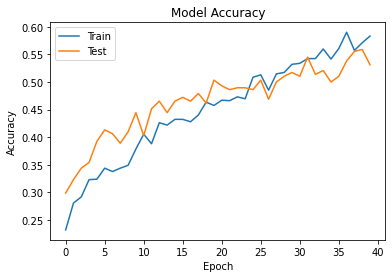

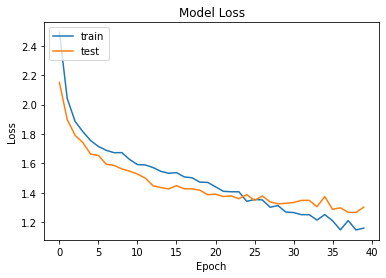

In [32]:
# Plotting model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

The accuracy on the test set is not at the same rate at the train set

In [33]:
# Loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

9/9 [==============================] - 0s 32ms/step - loss: 1.3026 - accuracy: 0.5312
Loss of the model is -  1.3025784492492676
9/9 [==============================] - 0s 34ms/step - loss: 1.3026 - accuracy: 0.5312
Accuracy of the model is -  53.125 %


In [34]:
# Predicted Label
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# Actual Labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# Looking at the together
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,sad
141,surprise,surprise
142,neutral,sad
143,sad,sad
144,fear,disgust
145,sad,sad
146,disgust,disgust
147,angry,angry
148,surprise,fear
149,angry,surprise


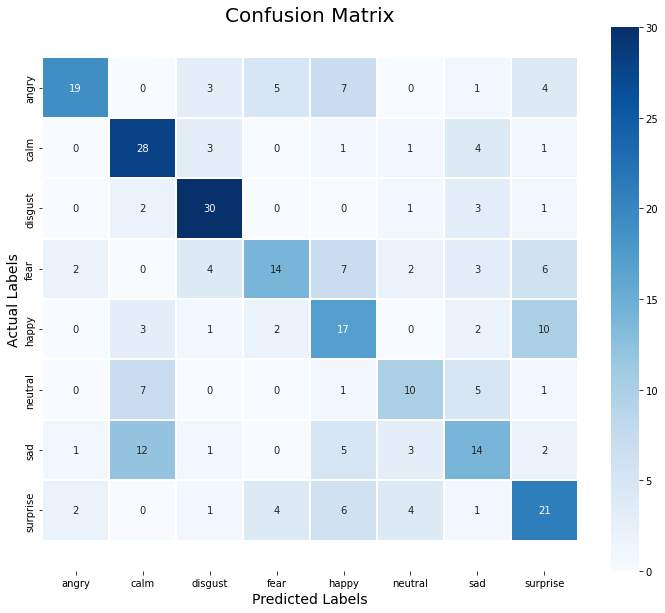

In [35]:
# Confusion Matrix 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [36]:
# Performance metrics
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.79      0.49      0.60        39
        calm       0.54      0.74      0.62        38
     disgust       0.70      0.81      0.75        37
        fear       0.56      0.37      0.44        38
       happy       0.39      0.49      0.43        35
     neutral       0.48      0.42      0.44        24
         sad       0.42      0.37      0.39        38
    surprise       0.46      0.54      0.49        39

    accuracy                           0.53       288
   macro avg       0.54      0.53      0.52       288
weighted avg       0.55      0.53      0.53       288



Accuracy of our initial 1D-CNN Model is 53%. Looking at the confusion matrix, we observe that the model is confused between sad and calm, neutral and calm, surprise and happy. This is why we see low precision for all these labels.



## Hyperparameter Tuning of 1D CNN Model

In [37]:
# Splitting data into training and testing sets
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print(X_test.shape)

(1152, 259)
(288, 259)


In [38]:
# Normalizing data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [39]:
# Transforming data into arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [40]:
# Reshaping data to include 3D tensors
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [41]:
from tensorflow.keras.utils import to_categorical

In [42]:
lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
# Function for keras classifier
opt = keras.optimizers.Adam(lr=0.0001)
def make_classifier(optimizer=opt):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(8, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
y_trainHot=np.argmax(y_train, axis=1)

In [45]:
# GridSearch for finding best parameters
classifier = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [25, 50, 75],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_trainHot)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8892 - accuracy: 0.1542


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 144ms/step - loss: 2.8634 - accuracy: 0.1846


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8701 - accuracy: 0.1876


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 126ms/step - loss: 2.8673 - accuracy: 0.1562


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 126ms/step - loss: 2.8961 - accuracy: 0.1714


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 126ms/step - loss: 2.8643 - accuracy: 0.1900


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8988 - accuracy: 0.1596


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.8648 - accuracy: 0.1876


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.8806 - accuracy: 0.1594


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8636 - accuracy: 0.1931


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 124ms/step - loss: 2.8951 - accuracy: 0.1509


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.8827 - accuracy: 0.1737


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8872 - accuracy: 0.1584


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8696 - accuracy: 0.1811


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 6s 161ms/step - loss: 2.8722 - accuracy: 0.1714


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8760 - accuracy: 0.1792


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8787 - accuracy: 0.1705


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8858 - accuracy: 0.1562


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 124ms/step - loss: 2.8785 - accuracy: 0.1551


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 124ms/step - loss: 2.8910 - accuracy: 0.1497


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.9033 - accuracy: 0.1390


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.8823 - accuracy: 0.1705


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 124ms/step - loss: 2.8935 - accuracy: 0.1659


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8888 - accuracy: 0.1486


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.8793 - accuracy: 0.1876


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 123ms/step - loss: 2.8782 - accuracy: 0.1640


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 124ms/step - loss: 2.8844 - accuracy: 0.1542


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 124ms/step - loss: 2.8852 - accuracy: 0.1659


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 125ms/step - loss: 2.8688 - accuracy: 0.1811


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


31/31 [==============================] - 5s 126ms/step - loss: 2.8674 - accuracy: 0.1909


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 134ms/step - loss: 2.8806 - accuracy: 0.1661


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 135ms/step - loss: 2.8745 - accuracy: 0.1650


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8861 - accuracy: 0.1768


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 131ms/step - loss: 2.8678 - accuracy: 0.1725


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 130ms/step - loss: 2.8855 - accuracy: 0.1811


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 131ms/step - loss: 2.8553 - accuracy: 0.1770


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8776 - accuracy: 0.1770


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8822 - accuracy: 0.1627


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 131ms/step - loss: 2.8829 - accuracy: 0.1638


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8777 - accuracy: 0.1833


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8814 - accuracy: 0.1759


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 134ms/step - loss: 2.8856 - accuracy: 0.1520


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8702 - accuracy: 0.1768


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 134ms/step - loss: 2.9057 - accuracy: 0.1573


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 135ms/step - loss: 2.8939 - accuracy: 0.1616


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.9057 - accuracy: 0.1629


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 135ms/step - loss: 2.8906 - accuracy: 0.1585


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8873 - accuracy: 0.1703


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 134ms/step - loss: 2.8753 - accuracy: 0.1757


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8952 - accuracy: 0.1497


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8589 - accuracy: 0.1607


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8943 - accuracy: 0.1466


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8710 - accuracy: 0.1811


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 133ms/step - loss: 2.8862 - accuracy: 0.1551


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 133ms/step - loss: 2.8855 - accuracy: 0.1714


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 131ms/step - loss: 2.8809 - accuracy: 0.1433


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.8736 - accuracy: 0.1629


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 134ms/step - loss: 2.8766 - accuracy: 0.1605


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 132ms/step - loss: 2.9136 - accuracy: 0.1508


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


29/29 [==============================] - 5s 131ms/step - loss: 2.8696 - accuracy: 0.1735


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 134ms/step - loss: 2.8827 - accuracy: 0.1607


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8950 - accuracy: 0.1585


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8801 - accuracy: 0.1887


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 137ms/step - loss: 2.8920 - accuracy: 0.1540


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 138ms/step - loss: 2.8771 - accuracy: 0.1594


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8987 - accuracy: 0.1542


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8716 - accuracy: 0.1759


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8938 - accuracy: 0.1757


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8960 - accuracy: 0.1475


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 137ms/step - loss: 2.8926 - accuracy: 0.1735


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8834 - accuracy: 0.2020


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8818 - accuracy: 0.1802


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8857 - accuracy: 0.1659


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8804 - accuracy: 0.1692


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8888 - accuracy: 0.1453


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8744 - accuracy: 0.1542


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 137ms/step - loss: 2.8944 - accuracy: 0.1542


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8871 - accuracy: 0.1746


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 134ms/step - loss: 2.8820 - accuracy: 0.1508


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8772 - accuracy: 0.1692


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.9091 - accuracy: 0.1553


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8779 - accuracy: 0.1726


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 4s 133ms/step - loss: 2.8876 - accuracy: 0.1768


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8930 - accuracy: 0.1410


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8790 - accuracy: 0.1735


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 136ms/step - loss: 2.8654 - accuracy: 0.1824


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 135ms/step - loss: 2.8739 - accuracy: 0.1574


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 138ms/step - loss: 2.8753 - accuracy: 0.1746


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 137ms/step - loss: 2.9007 - accuracy: 0.1345


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 5s 137ms/step - loss: 2.9006 - accuracy: 0.1388


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


36/36 [==============================] - 5s 131ms/step - loss: 2.8561 - accuracy: 0.1884


In [46]:
grid_search.best_params_

{'batch_size': 32, 'nb_epoch': 75, 'optimizer': 'SGD'}

In [47]:
grid_search.best_score_

0.2630227743271222

In [ ]:
y_true, grid_predictions = y_test, grid_search.predict(X_test)
 
# Performance metrics
print(classification_report(y_test, grid_predictions))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, grid_predictions)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()



### The grid search score validates that our initial model was overfitted.

## 1D CNN with Data Augmentation

Implementing data augmentation methods by adding noise, speed and pitch, and stretch to all audio files and using feature extraction methods to turn audio files into images to feed into 1D CNN Model

In [52]:
# Splitting data into training and testing
train,test = train_test_split(audio_df, test_size=0.2, random_state=0,
                               stratify=audio_df[['emotion','gender','actor']])

In [53]:
X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print(X_train.shape)

(1152, 1)


In [54]:
# Adding Noise, Stretch, Speed and Pitch to Original Audio Files

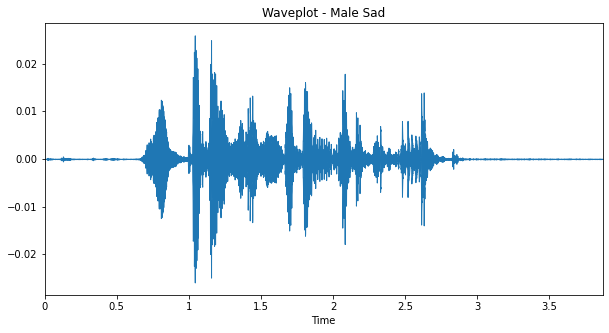

In [55]:
# Male sad original Audio file
fname = audio + 'Actor_09/03-01-04-02-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Male Sad')
plt.savefig('Waveplot_MaleSad.png')

In [56]:
sf.write('MaleSadOriginal.wav', np.random.randn(10, 2), 44100, 'PCM_24')
Audio(data=x, rate=sr)

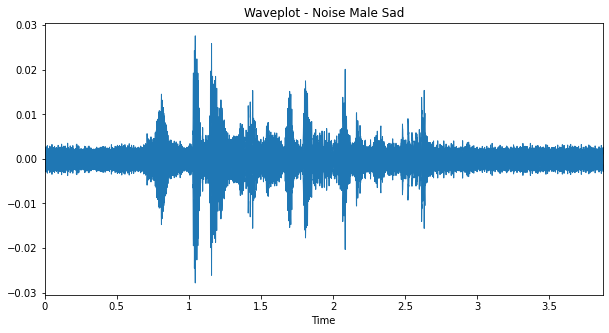

In [57]:
# Adding white noise
def noise(x):
    noise_amp = 0.05*np.random.uniform()*np.amax(x)   
    x = x.astype('float64') + noise_amp * np.random.normal(size=x.shape[0])
    return x

x = noise(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Noise Male Sad')
plt.savefig('Waveplot_MaleSadNoise.png')

In [58]:
# PLAY AUDIO FILE
sf.write('MaleSadNoise.wav', np.random.randn(10, 2), 44100, 'PCM_24')
Audio(data=x, rate=sr)

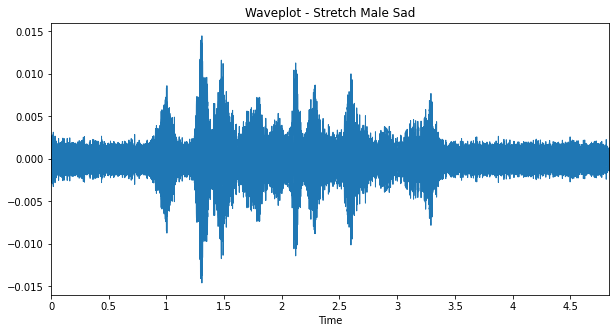

In [59]:
# Stretching the sound
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data

x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch Male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [60]:
sf.write('MaleSadStretch.wav', np.random.randn(10, 2), 44100, 'PCM_24')
Audio(data=x, rate=sr)

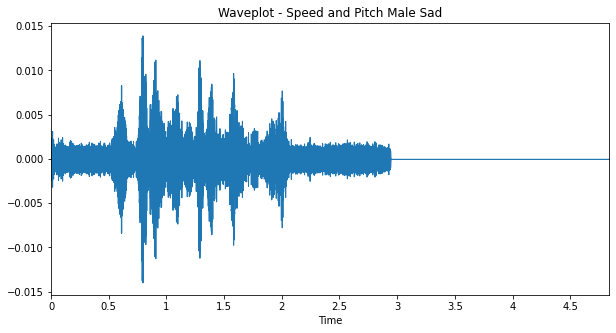

In [61]:
# Increasing speed and pitch
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [62]:
sf.write('MaleSadSpeedPitch.wav', np.random.randn(10, 2), 44100, 'PCM_24')
Audio(data=x, rate=sr)

In [63]:
# Apply Data Augmentation Methods to all audio files

In [64]:
# Feature extraction
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1152


,log_spec
0,"[-52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.0471, -51.851395, -51.810146, -51.825302, -51.442062, -50.395355, -49.357246, -48.650845, -47.61176, -45.85506, -44.482426, -44.37638, -43.91831, -42.559498, -37.76039, -37.65401, -41.90258, -41.855984, -41.126366, -40.958714, -41.220043, -41.09675, -41.059223, -41.465546, -40.57319, -39.823734, -39.06408, -39.5049, -39.611732, -38.462914, -39.361294, -39.030773, -38.666935, -40.95741, -45.016624, -44.794983, -44.775143, -44.765827, -45.013706, -44.88081, -44.902542, -45.993973, -47.306126, -37.388657, -22.739347, -19.092678, -20.123764, -19.599907, -16.071537, -14.275515, -14.762814, -16.547832, -16.895489, -16.773375, -16.280954, -15.185204, -13.293537, -12.109102, -12.385485, -13.076022, -15.451272, -20.106604, -24.0622, -25.46429, -27.309544, -27.774115, -22.29051, -22.004261, -25.226952, -27.177744, -26.733116, -21.037271, -18.779453, -20.99234, -21.492092, -17.9948, -13.951247, -11.518031, -12.270985, -15.77904, -18.952091, -17.195347, -17.019842, -20.731964, -25.268719, -28.579786, -30.081303, -32.305763, -33.67143, -34.151585, ...]"
1,"[-63.486824, -63.41773, -63.526535, -63.340748, -63.3857, -63.65437, -63.580883, -63.709644, -63.64708, -63.682728, -63.755096, -63.68291, -63.777416, -63.600925, -63.533867, -63.54886, -63.608906, -63.508118, -63.478413, -63.561287, -63.655857, -63.76259, -63.484154, -63.467934, -63.495953, -63.43409, -63.522896, -63.517906, -63.495842, -63.37938, -63.424454, -63.69458, -63.73528, -63.515793, -63.437855, -63.616455, -63.396286, -60.18054, -59.44299, -61.07015, -62.28503, -63.110916, -62.70409, -62.45038, -55.045277, -40.16046, -34.23301, -30.909845, -30.221851, -30.061365, -28.756922, -28.001545, -27.56802, -27.16275, -26.928791, -25.77891, -26.562992, -27.421135, -27.464294, -26.94044, -27.628017, -29.529755, -33.448612, -37.545357, -39.327694, -39.46922, -34.590256, -32.69544, -32.132614, -32.980125, -33.505436, -33.34773, -32.854042, -31.594734, -30.817629, -31.891268, -31.842762, -32.260963, -31.728304, -30.301105, -30.431372, -31.626177, -32.1834, -31.82549, -32.3424, -34.65566, -37.29207, -38.046257, -38.161755, -38.94152, -38.933563, -40.088642, -40.8073, -37.39368, -33.691963, -32.403347, -30.609917, -28.975824, -28.556175, -28.518312, ...]"
2,"[-67.91665, -67.91665, -67.8289, -67.345695, -67.37246, -67.76805, -67.541985, -64.76293, -56.2066, -53.97786, -54.883537, -55.651745, -61.529236, -63.194164, -62.7947, -62.169666, -61.039833, -59.529385, -57.363846, -56.302166, -55.809513, -55.193153, -54.602386, -54.45806, -54.525154, -55.86464, -56.573475, -57.599, -58.93836, -60.181465, -60.947144, -62.940914, -65.67919, -66.48235, -66.938194, -67.497925, -65.43671, -62.43317, -63.756393, -66.1322, -66.71754, -66.202, -65.9478, -37.410435, -27.712154, -24.19308, -22.465761, -22.509924, -23.085339, -23.14801, -21.83185, -22.054928, -20.461107, -18.8856, -21.75985, -26.798143, -29.653912, -34.28564, -38.218006, -39.941795, -38.728977, -32.910557, -32.56241, -34.3665, -35.55447, -36.23382, -34.211155, -28.539682, -28.333872, -27.488766, -26.797653, -28.885685, -30.912527, -32.502506, -33.679672, -32.384636, -30.928383, -31.6129, -34.203815, -37.69755, -39.69433, -41.185112, -42.253956, -43.110504, -41.318806, -39.1485, -35.866405, -32.749107, -31.906439, -33.133923, -33.062126, -33.76753, -35.845654, -38.52579, -34.442993, -32.175827, -30.833292, -29.831778, -29.461418, -28.533272, ...]"
3,"[-65.515594, -65.515594, -65.515594, -65.515594, -65.515594, -65.51534, -65.443596, -65.515594, -65.515594, -65.28474, -64.53719, -63.274635, -61.92858, -61.367493, -60.757736, -59.63441, -57.305313, -55.200764, -53.271233, -52.34172, -51.742916, -51.70317, -51.529953, -51.006363, -51.022625, -50.52558, -50.279564, -50.410923, -49.503822, -49.50164, -49.60622, -50.581654, -51.793034, -52.67696, -54.24565, -56.212414, -58.340263, -61.475517, -64.30425, -65.03406, -65.28588, -6

In [65]:
# Noise
df_noise = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # noise 
    aug = noise(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_noise.loc[counter] = [aug]
    counter +=1
print(len(df_noise))
df_noise.head()

1152


,feature
0,"[-52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.0471, -51.851395, -51.810146, -51.825302, -51.442062, -50.395355, -49.357246, -48.650845, -47.61176, -45.85506, -44.482426, -44.37638, -43.91831, -42.559498, -37.76039, -37.65401, -41.90258, -41.855984, -41.126366, -40.958714, -41.220043, -41.09675, -41.059223, -41.465546, -40.57319, -39.823734, -39.06408, -39.5049, -39.611732, -38.462914, -39.361294, -39.030773, -38.666935, -40.95741, -45.016624, -44.794983, -44.775143, -44.765827, -45.013706, -44.88081, -44.902542, -45.993973, -47.306126, -37.388657, -22.739347, -19.092678, -20.123764, -19.599907, -16.071537, -14.275515, -14.762814, -16.547832, -16.895489, -16.773375, -16.280954, -15.185204, -13.293537, -12.109102, -12.385485, -13.076022, -15.451272, -20.106604, -24.0622, -25.46429, -27.309544, -27.774115, -22.29051, -22.004261, -25.226952, -27.177744, -26.733116, -21.037271, -18.779453, -20.99234, -21.492092, -17.9948, -13.951247, -11.518031, -12.270985, -15.77904, -18.952091, -17.195347, -17.019842, -20.731964, -25.268719, -28.579786, -30.081303, -32.305763, -33.67143, -34.151585, ...]"
1,"[-63.486824, -63.41773, -63.526535, -63.340748, -63.3857, -63.65437, -63.580883, -63.709644, -63.64708, -63.682728, -63.755096, -63.68291, -63.777416, -63.600925, -63.533867, -63.54886, -63.608906, -63.508118, -63.478413, -63.561287, -63.655857, -63.76259, -63.484154, -63.467934, -63.495953, -63.43409, -63.522896, -63.517906, -63.495842, -63.37938, -63.424454, -63.69458, -63.73528, -63.515793, -63.437855, -63.616455, -63.396286, -60.18054, -59.44299, -61.07015, -62.28503, -63.110916, -62.70409, -62.45038, -55.045277, -40.16046, -34.23301, -30.909845, -30.221851, -30.061365, -28.756922, -28.001545, -27.56802, -27.16275, -26.928791, -25.77891, -26.562992, -27.421135, -27.464294, -26.94044, -27.628017, -29.529755, -33.448612, -37.545357, -39.327694, -39.46922, -34.590256, -32.69544, -32.132614, -32.980125, -33.505436, -33.34773, -32.854042, -31.594734, -30.817629, -31.891268, -31.842762, -32.260963, -31.728304, -30.301105, -30.431372, -31.626177, -32.1834, -31.82549, -32.3424, -34.65566, -37.29207, -38.046257, -38.161755, -38.94152, -38.933563, -40.088642, -40.8073, -37.39368, -33.691963, -32.403347, -30.609917, -28.975824, -28.556175, -28.518312, ...]"
2,"[-67.91665, -67.91665, -67.8289, -67.345695, -67.37246, -67.76805, -67.541985, -64.76293, -56.2066, -53.97786, -54.883537, -55.651745, -61.529236, -63.194164, -62.7947, -62.169666, -61.039833, -59.529385, -57.363846, -56.302166, -55.809513, -55.193153, -54.602386, -54.45806, -54.525154, -55.86464, -56.573475, -57.599, -58.93836, -60.181465, -60.947144, -62.940914, -65.67919, -66.48235, -66.938194, -67.497925, -65.43671, -62.43317, -63.756393, -66.1322, -66.71754, -66.202, -65.9478, -37.410435, -27.712154, -24.19308, -22.465761, -22.509924, -23.085339, -23.14801, -21.83185, -22.054928, -20.461107, -18.8856, -21.75985, -26.798143, -29.653912, -34.28564, -38.218006, -39.941795, -38.728977, -32.910557, -32.56241, -34.3665, -35.55447, -36.23382, -34.211155, -28.539682, -28.333872, -27.488766, -26.797653, -28.885685, -30.912527, -32.502506, -33.679672, -32.384636, -30.928383, -31.6129, -34.203815, -37.69755, -39.69433, -41.185112, -42.253956, -43.110504, -41.318806, -39.1485, -35.866405, -32.749107, -31.906439, -33.133923, -33.062126, -33.76753, -35.845654, -38.52579, -34.442993, -32.175827, -30.833292, -29.831778, -29.461418, -28.533272, ...]"
3,"[-65.515594, -65.515594, -65.515594, -65.515594, -65.515594, -65.51534, -65.443596, -65.515594, -65.515594, -65.28474, -64.53719, -63.274635, -61.92858, -61.367493, -60.757736, -59.63441, -57.305313, -55.200764, -53.271233, -52.34172, -51.742916, -51.70317, -51.529953, -51.006363, -51.022625, -50.52558, -50.279564, -50.410923, -49.503822, -49.50164, -49.60622, -50.581654, -51.793034, -52.67696, -54.24565, -56.212414, -58.340263, -61.475517, -64.30425, -65.03406, -65.28588, -65

In [66]:
# Speed and Pitch
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1152


,feature
0,"[-53.836918, -53.836918, -53.836918, -53.836918, -53.836918, -53.836918, -53.794044, -53.5154, -53.41684, -52.546047, -51.01186, -49.625996, -47.238388, -46.018055, -44.020508, -39.32672, -40.081524, -43.085857, -42.5693, -42.532364, -42.384933, -41.888374, -40.6174, -40.310123, -39.735394, -39.425194, -39.020134, -41.116093, -43.776825, -43.30554, -43.737354, -43.813873, -44.842075, -32.918457, -23.085577, -19.071228, -15.577705, -13.522397, -15.251012, -16.39303, -15.320001, -12.938189, -12.078675, -13.05781, -16.19187, -20.623997, -23.933231, -23.64237, -23.443033, -26.111195, -24.049662, -20.311949, -20.585531, -16.545916, -10.953284, -10.242649, -14.710762, -17.795134, -20.692911, -26.21263, -29.606138, -31.819357, -32.946194, -32.073425, -31.704693, -31.949173, -30.442602, -30.39598, -24.525991, -19.084385, -18.594988, -19.68377, -20.6506, -21.363422, -19.91832, -20.720364, -18.888784, -16.32227, -16.21849, -18.756657, -22.604097, -25.165947, -24.379416, -25.953733, -30.582073, -33.97745, -24.73715, -16.680113, -16.481316, -18.529623, -20.094107, -19.0472, -15.944862, -13.27213, -11.775652, -15.105343, -22.126745, -21.888641, -19.405163, -16.82936, ...]"
1,"[-64.774376, -64.76206, -64.620605, -64.71427, -64.93569, -64.99845, -65.004166, -65.08424, -65.09175, -64.91723, -64.87112, -64.89879, -64.77572, -64.876, -65.07737, -64.79941, -64.76641, -64.75082, -64.84145, -64.73022, -64.63319, -64.84868, -64.96823, -64.74368, -64.82316, -63.20775, -60.585503, -60.898415, -63.534172, -63.18021, -50.959087, -39.32362, -32.57367, -30.401495, -29.80552, -28.928381, -28.110556, -26.965914, -26.000696, -26.296892, -26.046358, -25.85454, -28.244726, -33.650402, -36.48338, -34.402588, -32.212147, -32.523445, -33.60234, -34.462994, -33.72553, -32.9187, -33.534966, -32.507202, -31.201185, -31.490873, -33.30781, -34.119907, -34.483944, -35.383804, -34.909023, -34.779953, -35.93349, -37.483997, -35.532345, -32.3005, -29.203228, -27.272049, -27.193512, -27.11821, -26.97046, -29.40947, -30.070265, -28.30848, -28.216131, -27.235947, -28.6666, -32.694614, -35.525005, -36.87672, -36.77475, -34.24597, -24.112005, -20.064919, -21.367847, -23.041733, -24.294193, -25.026451, -29.187943, -34.532593, -29.778446, -27.005371, -26.835527, -31.62788, -38.404266, -41.821213, -36.06477, -30.29373, -28.02517, -27.837597, ...]"
2,"[-68.13476, -68.061714, -67.61528, -67.84485, -61.738155, -55.782127, -55.42356, -59.653515, -63.287586, -62.094143, -59.18085, -57.127216, -56.117863, -55.68108, -55.64485, -57.526978, -59.182636, -60.78496, -63.095497, -66.39605, -67.398026, -64.17448, -62.838985, -65.642334, -61.56414, -36.967377, -26.253744, -22.040783, -23.099514, -23.549526, -20.101648, -19.715101, -23.82577, -30.559368, -35.605198, -35.458282, -35.212925, -37.77017, -37.61831, -30.981861, -25.93388, -25.505407, -28.918615, -30.826475, -31.241655, -34.617115, -38.741447, -42.424564, -44.1692, -44.03052, -38.022156, -33.2929, -32.132256, -33.305935, -34.982227, -33.49779, -28.707846, -26.785799, -26.057856, -27.627924, -30.881536, -34.387413, -37.031544, -36.03938, -27.353048, -24.725454, -24.730644, -23.593868, -24.908274, -26.33406, -31.101974, -36.459976, -30.711401, -28.865746, -30.016375, -33.908657, -40.995613, -44.46404, -36.74652, -26.244406, -20.781832, -20.660412, -24.171, -27.957666, -30.927416, -34.789776, -34.40195, -28.309864, -22.743341, -20.45444, -21.053783, -23.536074, -25.46468, -27.9594, -30.650145, -33.95439, -38.46141, -41.752724, -44.597187, -48.36935, ...]"
3,"[-66.57412, -66.57412, -66.57412, -66.573074, -66.57412, -66.40491, -65.479294, -63.525105, -62.415005, -60.654392, -57.27881, -54.768013, -53.416107, -53.15282, -52.80709, -52.416515, -52.298447, -51.656673, -51.209743, -52.439133, -54.230846, -56.82211, -60.248466, -64.37453, -66.124374, -66.08611, -49.814693, -34.977757, -30.002968, -30.050825, -31.984037, -32.294617, -31.270176, -28.713493, -25.020222, -23.825396, -23.783821, -23.028296, -24.042114, -26.549149, -29.

In [67]:
# Stretch
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(train.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1152


,feature
0,"[-52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.10011, -52.0471, -51.851395, -51.810146, -51.825302, -51.442062, -50.395355, -49.357246, -48.650845, -47.61176, -45.85506, -44.482426, -44.37638, -43.91831, -42.559498, -37.76039, -37.65401, -41.90258, -41.855984, -41.126366, -40.958714, -41.220043, -41.09675, -41.059223, -41.465546, -40.57319, -39.823734, -39.06408, -39.5049, -39.611732, -38.462914, -39.361294, -39.030773, -38.666935, -40.95741, -45.016624, -44.794983, -44.775143, -44.765827, -45.013706, -44.88081, -44.902542, -45.993973, -47.306126, -37.388657, -22.739347, -19.092678, -20.123764, -19.599907, -16.071537, -14.275515, -14.762814, -16.547832, -16.895489, -16.773375, -16.280954, -15.185204, -13.293537, -12.109102, -12.385485, -13.076022, -15.451272, -20.106604, -24.0622, -25.46429, -27.309544, -27.774115, -22.29051, -22.004261, -25.226952, -27.177744, -26.733116, -21.037271, -18.779453, -20.99234, -21.492092, -17.9948, -13.951247, -11.518031, -12.270985, -15.77904, -18.952091, -17.195347, -17.019842, -20.731964, -25.268719, -28.579786, -30.081303, -32.305763, -33.67143, -34.151585, ...]"
1,"[-63.486824, -63.41773, -63.526535, -63.340748, -63.3857, -63.65437, -63.580883, -63.709644, -63.64708, -63.682728, -63.755096, -63.68291, -63.777416, -63.600925, -63.533867, -63.54886, -63.608906, -63.508118, -63.478413, -63.561287, -63.655857, -63.76259, -63.484154, -63.467934, -63.495953, -63.43409, -63.522896, -63.517906, -63.495842, -63.37938, -63.424454, -63.69458, -63.73528, -63.515793, -63.437855, -63.616455, -63.396286, -60.18054, -59.44299, -61.07015, -62.28503, -63.110916, -62.70409, -62.45038, -55.045277, -40.16046, -34.23301, -30.909845, -30.221851, -30.061365, -28.756922, -28.001545, -27.56802, -27.16275, -26.928791, -25.77891, -26.562992, -27.421135, -27.464294, -26.94044, -27.628017, -29.529755, -33.448612, -37.545357, -39.327694, -39.46922, -34.590256, -32.69544, -32.132614, -32.980125, -33.505436, -33.34773, -32.854042, -31.594734, -30.817629, -31.891268, -31.842762, -32.260963, -31.728304, -30.301105, -30.431372, -31.626177, -32.1834, -31.82549, -32.3424, -34.65566, -37.29207, -38.046257, -38.161755, -38.94152, -38.933563, -40.088642, -40.8073, -37.39368, -33.691963, -32.403347, -30.609917, -28.975824, -28.556175, -28.518312, ...]"
2,"[-67.91665, -67.91665, -67.8289, -67.345695, -67.37246, -67.76805, -67.541985, -64.76293, -56.2066, -53.97786, -54.883537, -55.651745, -61.529236, -63.194164, -62.7947, -62.169666, -61.039833, -59.529385, -57.363846, -56.302166, -55.809513, -55.193153, -54.602386, -54.45806, -54.525154, -55.86464, -56.573475, -57.599, -58.93836, -60.181465, -60.947144, -62.940914, -65.67919, -66.48235, -66.938194, -67.497925, -65.43671, -62.43317, -63.756393, -66.1322, -66.71754, -66.202, -65.9478, -37.410435, -27.712154, -24.19308, -22.465761, -22.509924, -23.085339, -23.14801, -21.83185, -22.054928, -20.461107, -18.8856, -21.75985, -26.798143, -29.653912, -34.28564, -38.218006, -39.941795, -38.728977, -32.910557, -32.56241, -34.3665, -35.55447, -36.23382, -34.211155, -28.539682, -28.333872, -27.488766, -26.797653, -28.885685, -30.912527, -32.502506, -33.679672, -32.384636, -30.928383, -31.6129, -34.203815, -37.69755, -39.69433, -41.185112, -42.253956, -43.110504, -41.318806, -39.1485, -35.866405, -32.749107, -31.906439, -33.133923, -33.062126, -33.76753, -35.845654, -38.52579, -34.442993, -32.175827, -30.833292, -29.831778, -29.461418, -28.533272, ...]"
3,"[-65.515594, -65.515594, -65.515594, -65.515594, -65.515594, -65.51534, -65.443596, -65.515594, -65.515594, -65.28474, -64.53719, -63.274635, -61.92858, -61.367493, -60.757736, -59.63441, -57.305313, -55.200764, -53.271233, -52.34172, -51.742916, -51.70317, -51.529953, -51.006363, -51.022625, -50.52558, -50.279564, -50.410923, -49.503822, -49.50164, -49.60622, -50.581654, -51.793034, -52.67696, -54.24565, -56.212414, -58.340263, -61.475517, -64.30425, -65.03406, -65.28588, -65

In [68]:
# Combining Tables For Modelling

In [69]:
# Extracting emotion labels from training set
labels = train.emotion
labels.reset_index(drop=True, inplace=True)
labels

0       angry   
1       surprise
2       surprise
3       surprise
4       surprise
          ...   
1147    angry   
1148    sad     
1149    sad     
1150    calm    
1151    fear    
Name: emotion, Length: 1152, dtype: object

In [70]:
# Adding labels
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
mfcc = pd.concat([mfcc_df,labels], axis=1,ignore_index=True)
mfcc = mfcc.rename(index=str, columns={259: "emotion"})

noise_df = pd.DataFrame(df_noise['feature'].values.tolist())
noise = pd.concat([noise_df,labels], axis=1)
noise = noise.rename(index=str, columns={259: "label"})

speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={259: "label"})

stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={259: "label"})

In [71]:
# joining data frames for final dataframe
combined_df = pd.concat([mfcc, noise, speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.tail()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,emotion
4603,-50.013554,-49.987030,-49.950630,-49.989876,-50.013554,-50.013554,-50.012203,-49.983894,-49.986824,-50.013554,...,-49.733475,-49.939636,-49.861298,-49.786304,-49.797840,-49.718586,-49.726868,-49.980240,-49.962204,angry
4604,-67.904999,-67.943665,-68.031281,-67.961525,-67.885712,-68.044617,-68.102264,-68.009331,-67.908081,-67.852127,...,-67.771706,-67.718842,-67.534889,-67.411179,-67.642990,-67.714569,-67.876793,-67.729774,-67.574707,sad
4605,-77.548431,-77.537270,-77.459946,-77.396561,-77.548431,-77.548431,-77.548431,-77.517204,-77.548431,-77.548431,...,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,-77.548431,sad
4606,-82.734825,-79.602737,-77.126938,-76.456169,-77.006424,-76.750793,-76.038513,-75.667809,-75.560844,-76.109756,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,calm
4607,-69.922836,-69.970703,-69.970703,-69.919693,-69.685371,-69.406242,-69.049988,-69.162704,-69.687843,-69.828552,...,-69.970703,-69.970703,-69.970703,-69.970703,-69.970703,-69.970703,-69.970703,-69.847031,-69.292488,fear


In [72]:
mfcc.shape

(1152, 260)

In [73]:
noise.shape

(1152, 260)

In [74]:
speedpitch.shape

(1152, 260)

In [75]:
stretch.shape

(1152, 260)

In [76]:
X_train = combined_df.iloc[:, :-1]
y_train = combined_df.iloc[:, -1:]

In [77]:
# Feature Extraction for Test Set

In [78]:
# Extracting log mel spectogram means for modelling
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(test.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df))
df.head()

288


,mel_spectrogram
0,"[-51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -51.84067, -49.875393, -45.11929, -40.570328, -36.394356, -33.24894, -31.565962, -30.460361, -30.468588, -31.624968, -32.706276, -34.649055, -37.88446, -42.11642, -45.09913, -45.39301, -48.29825, -50.917854, -45.239746, -29.419369, -24.319584, -23.441492, -23.45615, -23.375826, -24.093723, -24.724516, -23.36017, -19.85293, -17.805544, -18.25066, -19.407412, -20.357069, -23.630964, -28.531076, -32.395786, -33.640232, -32.00335, -28.813255, -24.610235, -21.865803, -17.321447, -16.056593, -18.919954, -21.350294, -21.648222, -19.258556, -19.654528, -25.097658, -31.525583, -26.436047, -21.512032, -21.509804, -21.2961, -20.84073, -20.509108, -20.08636, -17.936584, -17.437479, -18.895681, -19.580757, -19.884974, -21.949347, -22.41349, -23.189907, -20.107325, -22.098995, -26.999037, -30.328968, -30.837746, -28.245356, -25.123657, -24.008268, -25.363499, -24.277252, ...]"
1,"[-67.77097, -67.029076, -66.100296, -64.073975, -63.793278, -64.50941, -64.79417, -65.52241, -65.42038, -63.55962, -62.217278, -62.311947, -63.354084, -63.611412, -63.53419, -63.510216, -63.908348, -63.93902, -64.36756, -64.27445, -65.35977, -66.404434, -66.30486, -66.035675, -67.25207, -67.99162, -68.90149, -69.55514, -71.30018, -72.18077, -71.77888, -71.4658, -71.22502, -71.07854, -70.8014, -71.28698, -70.50367, -67.54658, -66.75481, -65.22033, -64.404625, -65.10031, -66.69391, -48.82524, -34.92373, -30.924858, -29.289314, -28.446465, -28.60479, -28.881443, -29.032877, -30.563745, -31.629549, -32.041466, -31.271578, -30.436726, -29.87748, -29.931149, -29.683935, -30.58484, -33.812046, -37.25844, -39.221294, -40.25858, -39.90263, -35.853252, -33.43405, -32.65965, -32.780033, -32.755947, -32.153755, -31.79792, -32.446476, -32.107094, -31.91945, -33.315014, -33.928986, -35.846786, -37.72196, -36.23094, -33.117603, -30.81037, -30.611856, -31.973442, -33.659542, -35.500404, -35.952747, -36.04111, -36.174408, -35.92896, -36.34135, -36.881, -35.665085, -35.076393, -33.793972, -34.64616, -34.941742, -35.282745, -36.01873, -36.345703, ...]"
2,"[-52.238705, -52.015965, -51.746494, -51.12382, -50.7957, -50.6528, -50.606216, -49.77016, -48.881454, -48.10207, -47.558136, -46.56286, -44.483524, -43.863712, -43.760994, -42.29379, -41.432037, -40.45523, -39.664673, -39.315807, -39.780285, -39.374916, -39.488144, -39.58687, -39.54572, -37.960365, -38.379356, -39.974846, -42.13071, -44.124516, -46.24411, -48.209785, -50.659332, -52.37483, -51.88225, -51.987167, -52.651463, -53.084923, -53.128124, -53.184032, -53.232944, -53.228966, -39.03149, -25.983324, -22.046894, -20.025229, -19.896307, -20.968748, -21.978468, -21.544266, -19.618656, -17.45998, -16.531187, -16.722563, -18.312017, -19.13561, -19.304895, -23.851736, -29.9896, -32.6927, -35.26669, -33.853573, -32.464897, -32.022705, -30.131247, -26.32588, -21.105062, -21.109308, -23.120605, -25.431246, -28.082127, -26.139877, -26.50124, -32.161957, -36.93336, -39.356903, -42.519207, -39.629395, -25.605848, -20.27047, -20.291086, -21.251183, -21.367603, -21.629454, -22.385899, -23.375517, -23.37589, -22.923466, -22.310045, -22.429293, -22.321676, -21.638945, -21.909132, -18.047966, -13.583408, -13.622357, -16.204773, -20.666645, -26.658024, -31.098053, ...]"
3,"[-47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.162098, -47.159935, -47.134632, -46.817932, -46.99923, -47.093693, -47.080967, -46.993076, -46.930763, -46.897156, -46.841076

In [79]:
test.reset_index(drop=True,inplace=True)

In [80]:
# attaching emotion labels
df_combined = pd.concat([test,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_04/03-01-06-02-01-02-04.wav,-51.840672,-51.840672,-51.840672,-51.840672,-51.840672,-51.840672,...,-51.840672,-51.840672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,calm,21,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_21/03-01-02-01-02-02-21.wav,-67.770973,-67.029076,-66.100296,-64.073975,-63.793278,-64.509407,...,-69.713272,-69.830238,-71.018738,-71.019531,-70.774048,-70.607124,-71.470352,-72.666916,-72.066116,-71.304047
2,female,happy,16,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_16/03-01-03-02-01-02-16.wav,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_12/03-01-05-02-01-02-12.wav,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,...,-46.379883,-46.451462,-46.434490,-46.435925,-46.471390,-46.708366,-46.792576,-46.639893,-46.397442,-46.686069
4,male,fear,23,/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_23/03-01-06-02-01-02-23.wav,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,...,-64.129486,-64.129486,-64.129486,-64.129486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [81]:
# dropping path column
df_combined.drop(columns='path',inplace=True)

In [82]:
# checking data
print(df_combined.shape)
df_combined.head()

(288, 262)


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,female,fear,4,-51.840672,-51.840672,-51.840672,-51.840672,-51.840672,-51.840672,-51.840672,...,-51.840672,-51.840672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,calm,21,-67.770973,-67.029076,-66.100296,-64.073975,-63.793278,-64.509407,-64.794167,...,-69.713272,-69.830238,-71.018738,-71.019531,-70.774048,-70.607124,-71.470352,-72.666916,-72.066116,-71.304047
2,female,happy,16,-52.238705,-52.015965,-51.746494,-51.123821,-50.795700,-50.652802,-50.606216,...,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944,-53.232944
3,female,angry,12,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,-47.162098,...,-46.379883,-46.451462,-46.434490,-46.435925,-46.471390,-46.708366,-46.792576,-46.639893,-46.397442,-46.686069
4,male,fear,23,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,-64.129486,...,-64.129486,-64.129486,-64.129486,-64.129486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [83]:
# separating for x_test and y_test
X_test = df_combined.iloc[:, 3:]
y_test = df_combined.iloc[:,:2].drop(columns=['gender'])

In [84]:
# Normalizing data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [85]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [87]:
# One hot encoding
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [89]:
# Reshaping to 3D
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(288, 259, 1)

In [90]:
X_train.shape[0]

4608

In [91]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Building 1D CNN layers
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))

model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)

Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_276 (Conv1D)         (None, 240, 64)           1344      
                                                                 
 conv1d_277 (Conv1D)         (None, 221, 128)          163968    
                                                                 
 max_pooling1d_184 (MaxPooli  (None, 27, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_276 (Dropout)       (None, 27, 128)           0         
                                                                 
 conv1d_278 (Conv1D)         (None, 8, 128)            327808    
                                                                 
 max_pooling1d_185 (MaxPooli  (None, 1, 128)           0         
 ng1D)                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [92]:
checkpoint = ModelCheckpoint('face_detector.h15', monitor= 'val_loss', mode= 'min', save_best_only = True, verbose= 1)

# Model fitting
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=8, epochs=20, validation_data=(X_test, y_test),callbacks=checkpoint)

Epoch 1/20
576/576 [==============================] - ETA: 0s - loss: 2.3123 - accuracy: 0.2771
Epoch 1: val_loss improved from inf to 1.96433, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
576/576 [==============================] - 38s 65ms/step - loss: 2.3123 - accuracy: 0.2771 - val_loss: 1.9643 - val_accuracy: 0.3194
Epoch 2/20
576/576 [==============================] - ETA: 0s - loss: 1.8772 - accuracy: 0.3433
Epoch 2: val_loss improved from 1.96433 to 1.71781, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
576/576 [==============================] - 37s 64ms/step - loss: 1.8772 - accuracy: 0.3433 - val_loss: 1.7178 - val_accuracy: 0.3889
Epoch 3/20
576/576 [==============================] - ETA: 0s - loss: 1.7121 - accuracy: 0.3702
Epoch 3: val_loss improved from 1.71781 to 1.62508, saving model to face_detector.h15
INFO:tensorflow:Assets written to: face_detector.h15/assets
576/576 [===

In [93]:
# Saving model
model.save_weights("best_model_weights.h5")
model.save('best_model.h5')
print("Saved model to disk")

Saved model to disk


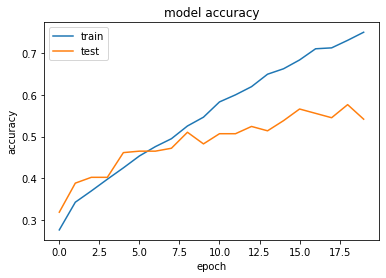

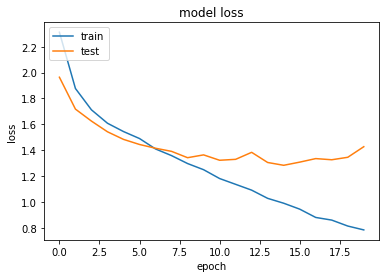

In [94]:
# Model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()


The model started out well but with increasing epochs we see overfitting

In [95]:
# predicted labels
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# looking at them together
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,sad,calm
141,surprise,angry
142,neutral,calm
143,sad,sad
144,fear,disgust
145,sad,sad
146,disgust,disgust
147,angry,angry
148,surprise,surprise
149,angry,surprise


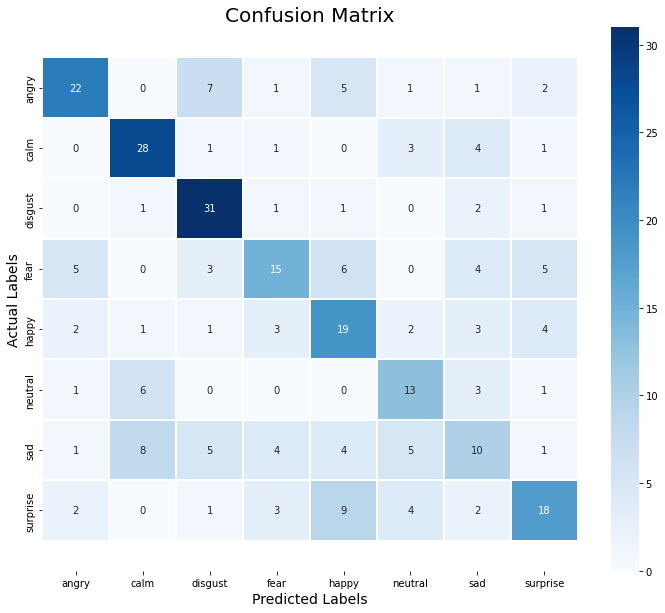

In [96]:
# confusion matrix
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [97]:
# performance metrics
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.67      0.56      0.61        39
        calm       0.64      0.74      0.68        38
     disgust       0.63      0.84      0.72        37
        fear       0.54      0.39      0.45        38
       happy       0.43      0.54      0.48        35
     neutral       0.46      0.54      0.50        24
         sad       0.34      0.26      0.30        38
    surprise       0.55      0.46      0.50        39

    accuracy                           0.54       288
   macro avg       0.53      0.54      0.53       288
weighted avg       0.54      0.54      0.53       288



The accuracy increased slightly from 53% to 54% and the precision on happy, sad, neutral, calm and surprised increased as well.

### Hyperparameter Tuning of 1D CNN Model(with Data Augmentation)

In [98]:
from sklearn.model_selection import StratifiedShuffleSplit

In [99]:
# Stratifies Shuffle Split
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
SSS = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in SSS.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [100]:
# Normalizing data
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [101]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [102]:
# reshaping data to 3d tensor
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

In [103]:
# Function for keras classifer
def make_classifier(optimizer='adam'):
    #BUILD CNN MODEL
    model = Sequential()
    model.add(Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    model.summary()
    opt = keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model


In [104]:
# Finding best parameters
model = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [50, 75, 100],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=model,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_279 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_280 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_186 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_279 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_281 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_187 (MaxPooli  (None, 2, 128)           0         
 ng1D)                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 122ms/step - loss: 2.0985 - accuracy: 0.2670
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_282 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_283 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_188 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_282 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_284 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_189 (MaxPooli 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 122ms/step - loss: 2.0975 - accuracy: 0.2706
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_285 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_286 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_190 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_285 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_287 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_191 (MaxPooli 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 125ms/step - loss: 2.0989 - accuracy: 0.2689
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_288 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_289 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_192 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_288 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_290 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_193 (MaxPooli 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1028 - accuracy: 0.2682
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_291 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_292 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_194 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_291 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_293 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_195 (MaxPooli 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1087 - accuracy: 0.2635
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_294 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_295 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_196 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_294 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_296 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_197 (MaxPooli 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1209 - accuracy: 0.2724
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_297 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_298 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_198 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_297 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_299 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_199 (MaxPooli 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 122ms/step - loss: 2.1131 - accuracy: 0.2584
Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_300 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_301 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_200 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_300 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_302 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_201 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.1071 - accuracy: 0.2618
Model: "sequential_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_303 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_304 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_202 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_303 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_305 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_203 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.0747 - accuracy: 0.2631
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_306 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_307 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_204 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_306 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_308 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_205 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.0899 - accuracy: 0.2614
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_309 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_310 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_206 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_309 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_311 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_207 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.0943 - accuracy: 0.2700
Model: "sequential_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_312 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_313 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_208 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_312 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_314 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_209 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1028 - accuracy: 0.2608
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_315 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_316 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_210 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_315 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_317 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_211 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 121ms/step - loss: 2.1099 - accuracy: 0.2584
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_318 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_319 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_212 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_318 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_320 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_213 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1025 - accuracy: 0.2655
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_321 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_322 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_214 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_321 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_323 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_215 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1141 - accuracy: 0.2784
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_324 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_325 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_216 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_324 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_326 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_217 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1091 - accuracy: 0.2564
Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_327 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_328 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_218 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_327 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_329 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_219 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.0926 - accuracy: 0.2713
Model: "sequential_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_330 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_331 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_220 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_330 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_332 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_221 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.1060 - accuracy: 0.2621
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_333 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_334 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_222 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_333 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_335 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_223 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.0794 - accuracy: 0.2909
Model: "sequential_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_336 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_337 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_224 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_336 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_338 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_225 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1068 - accuracy: 0.2614
Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_339 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_340 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_226 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_339 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_341 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_227 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.1361 - accuracy: 0.2609
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_342 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_343 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_228 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_342 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_344 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_229 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.1010 - accuracy: 0.2730
Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_345 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_346 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_230 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_345 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_347 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_231 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.1086 - accuracy: 0.2519
Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_348 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_349 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_232 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_348 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_350 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_233 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.1045 - accuracy: 0.2659
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_351 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_352 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_234 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_351 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_353 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_235 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 122ms/step - loss: 2.1169 - accuracy: 0.2665
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_354 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_355 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_236 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_354 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_356 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_237 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 125ms/step - loss: 2.0794 - accuracy: 0.2636
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_357 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_358 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_238 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_357 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_359 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_239 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.0942 - accuracy: 0.2692
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_360 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_361 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_240 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_360 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_362 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_241 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 123ms/step - loss: 2.0913 - accuracy: 0.2642
Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_363 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_364 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_242 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_363 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_365 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_243 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 124ms/step - loss: 2.1170 - accuracy: 0.2625
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_366 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_367 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_244 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_366 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_368 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_245 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


99/99 [==============================] - 13s 125ms/step - loss: 2.1006 - accuracy: 0.2645
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_369 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_370 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_246 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_369 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_371 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_247 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1121 - accuracy: 0.2734
Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_372 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_373 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_248 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_372 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_374 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_249 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1179 - accuracy: 0.2628
Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_375 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_376 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_250 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_375 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_377 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_251 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 130ms/step - loss: 2.0953 - accuracy: 0.2655
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_378 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_379 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_252 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_378 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_380 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_253 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1210 - accuracy: 0.2465
Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_381 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_382 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_254 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_381 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_383 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_255 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1288 - accuracy: 0.2577
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_384 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_385 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_256 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_384 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_386 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_257 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1030 - accuracy: 0.2629
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_387 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_388 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_258 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_387 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_389 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_259 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.0848 - accuracy: 0.2665
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_390 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_391 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_260 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_390 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_392 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_261 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1136 - accuracy: 0.2591
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_393 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_394 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_262 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_393 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_395 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_263 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1202 - accuracy: 0.2628
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_396 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_397 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_264 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_396 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_398 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_265 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1228 - accuracy: 0.2618
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_399 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_400 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_266 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_399 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_401 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_267 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 134ms/step - loss: 2.1261 - accuracy: 0.2615
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_402 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_403 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_268 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_402 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_404 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_269 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1193 - accuracy: 0.2587
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_405 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_406 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_270 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_405 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_407 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_271 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1011 - accuracy: 0.2652
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_408 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_409 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_272 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_408 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_410 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_273 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1204 - accuracy: 0.2645
Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_411 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_412 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_274 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_411 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_413 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_275 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1115 - accuracy: 0.2713
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_414 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_415 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_276 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_414 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_416 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_277 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1187 - accuracy: 0.2649
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_417 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_418 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_278 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_417 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_419 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_279 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1130 - accuracy: 0.2638
Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_420 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_421 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_280 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_420 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_422 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_281 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1310 - accuracy: 0.2509
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_423 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_424 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_282 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_423 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_425 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_283 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1072 - accuracy: 0.2638
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_426 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_427 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_284 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_426 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_428 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_285 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1060 - accuracy: 0.2665
Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_429 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_430 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_286 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_429 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_431 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_287 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1123 - accuracy: 0.2714
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_432 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_433 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_288 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_432 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_434 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_289 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1094 - accuracy: 0.2720
Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_435 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_436 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_290 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_435 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_437 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_291 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1054 - accuracy: 0.2638
Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_438 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_439 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_292 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_438 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_440 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_293 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1084 - accuracy: 0.2716
Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_441 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_442 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_294 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_441 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_443 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_295 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1281 - accuracy: 0.2560
Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_444 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_445 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_296 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_444 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_446 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_297 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 131ms/step - loss: 2.1198 - accuracy: 0.2626
Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_447 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_448 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_298 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_447 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_449 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_299 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 133ms/step - loss: 2.1174 - accuracy: 0.2659
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_450 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_451 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_300 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_450 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_452 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_301 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1117 - accuracy: 0.2675
Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_453 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_454 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_302 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_453 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_455 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_303 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 134ms/step - loss: 2.1063 - accuracy: 0.2716
Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_456 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_457 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_304 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_456 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_458 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_305 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


93/93 [==============================] - 13s 132ms/step - loss: 2.1099 - accuracy: 0.2747
Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_459 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_460 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_306 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_459 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_461 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_307 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 139ms/step - loss: 2.1184 - accuracy: 0.2771
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_462 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_463 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_308 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_462 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_464 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_309 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.1235 - accuracy: 0.2781
Model: "sequential_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_465 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_466 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_310 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_465 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_467 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_311 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 139ms/step - loss: 2.1370 - accuracy: 0.2652
Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_468 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_469 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_312 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_468 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_470 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_313 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1171 - accuracy: 0.2540
Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_471 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_472 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_314 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_471 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_473 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_315 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1267 - accuracy: 0.2570
Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_474 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_475 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_316 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_474 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_476 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_317 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1354 - accuracy: 0.2693
Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_477 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_478 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_318 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_477 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_479 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_319 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 142ms/step - loss: 2.1147 - accuracy: 0.2655
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_480 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_481 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_320 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_480 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_482 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_321 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1198 - accuracy: 0.2587
Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_483 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_484 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_322 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_483 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_485 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_323 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.1293 - accuracy: 0.2594
Model: "sequential_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_486 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_487 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_324 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_486 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_488 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_325 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.1233 - accuracy: 0.2669
Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_489 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_490 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_326 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_489 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_491 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_327 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 143ms/step - loss: 2.1264 - accuracy: 0.2639
Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_492 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_493 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_328 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_492 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_494 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_329 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.0957 - accuracy: 0.2642
Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_495 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_496 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_330 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_495 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_497 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_331 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.1053 - accuracy: 0.2635
Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_498 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_499 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_332 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_498 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_500 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_333 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 142ms/step - loss: 2.1529 - accuracy: 0.2564
Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_501 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_502 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_334 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_501 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_503 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_335 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.1440 - accuracy: 0.2465
Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_504 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_505 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_336 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_504 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_506 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_337 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.0979 - accuracy: 0.2670
Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_507 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_508 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_338 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_507 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_509 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_339 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 140ms/step - loss: 2.1113 - accuracy: 0.2618
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_510 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_511 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_340 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_510 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_512 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_341 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1118 - accuracy: 0.2672
Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_513 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_514 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_342 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_513 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_515 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_343 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 17s 189ms/step - loss: 2.1137 - accuracy: 0.2625
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_516 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_517 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_344 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_516 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_518 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_345 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1324 - accuracy: 0.2489
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_519 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_520 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_346 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_519 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_521 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_347 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 141ms/step - loss: 2.1270 - accuracy: 0.2670
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_522 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_523 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_348 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_522 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_524 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_349 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 142ms/step - loss: 2.1231 - accuracy: 0.2764
Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_525 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_526 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_350 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_525 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_527 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_351 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 142ms/step - loss: 2.1341 - accuracy: 0.2513
Model: "sequential_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_528 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_529 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_352 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_528 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_530 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_353 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 142ms/step - loss: 2.1254 - accuracy: 0.2672
Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_531 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_532 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_354 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_531 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_533 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_355 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 15s 160ms/step - loss: 2.1403 - accuracy: 0.2543
Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_534 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_535 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_356 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_534 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_536 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_357 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 142ms/step - loss: 2.1230 - accuracy: 0.2724
Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_537 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_538 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_358 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_537 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_539 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_359 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 143ms/step - loss: 2.1096 - accuracy: 0.2753
Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_540 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_541 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_360 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_540 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_542 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_361 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 144ms/step - loss: 2.1210 - accuracy: 0.2611
Model: "sequential_181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_543 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_544 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_362 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_543 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_545 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_363 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 143ms/step - loss: 2.1334 - accuracy: 0.2635
Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_546 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_547 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_364 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_546 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_548 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_365 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


87/87 [==============================] - 13s 144ms/step - loss: 2.1243 - accuracy: 0.2669
Model: "sequential_183"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_549 (Conv1D)         (None, 250, 64)           704       
                                                                 
 conv1d_550 (Conv1D)         (None, 241, 128)          82048     
                                                                 
 max_pooling1d_366 (MaxPooli  (None, 30, 128)          0         
 ng1D)                                                           
                                                                 
 dropout_549 (Dropout)       (None, 30, 128)           0         
                                                                 
 conv1d_551 (Conv1D)         (None, 21, 128)           163968    
                                                                 
 max_pooling1d_367 (MaxPooli

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


116/116 [==============================] - 18s 146ms/step - loss: 2.0387 - accuracy: 0.2670
{'batch_size': 32, 'nb_epoch': 75, 'optimizer': 'SGD'}
0.31770085272087456


In [105]:
print(grid_search.best_score_)

0.31770085272087456


In [106]:
y_true, grid_predictions = y_test, grid_search.predict(X_test)
 
# Performance metrics
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

       angry       0.31      0.65      0.42       122
        calm       0.45      0.47      0.46       123
     disgust       0.32      0.40      0.36       124
        fear       0.00      0.00      0.00       123
       happy       0.15      0.13      0.14       126
     neutral       0.00      0.00      0.00        58
         sad       0.32      0.33      0.32       123
    surprise       0.27      0.34      0.30       123

    accuracy                           0.31       922
   macro avg       0.23      0.29      0.25       922
weighted avg       0.24      0.31      0.27       922



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


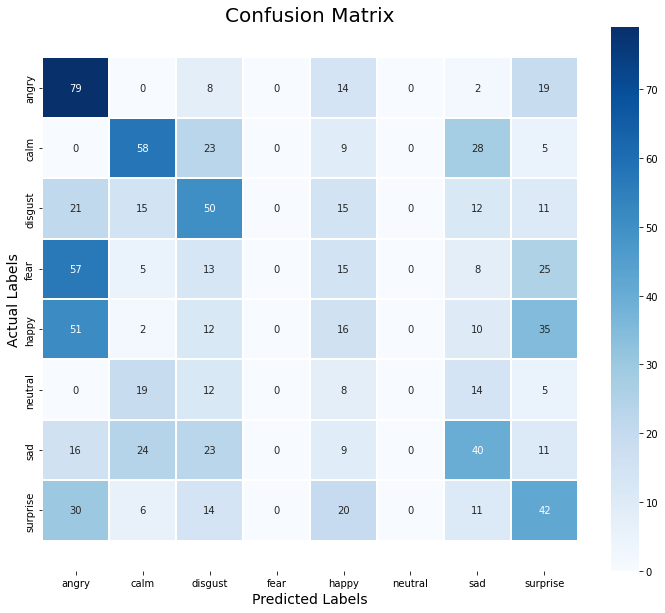

In [107]:
# Confusion Matrix
cm = confusion_matrix(y_test, grid_predictions)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()


The confusion matrix indicates that labels fear and anger, happy and anger, happy and surprise were not predicted accurat;y. This could be due to these audio files having similar images since all of them can be high in pitch and speed.

# **MLP Classifier**
The Multilayer Perceptron (MLP) is a type of artificial neural network that is fed forward (ANN). MLP utilizes a supervised learning technique called backpropagation for
training. MLP is distinguished from a linear perceptron by its numerous layers and non-linear activation. It can tell the difference between data that isn't linearly separable.

In [108]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

# defined RAVDESS emotions to test on RAVDESS dataset 
ravdess_emotions=['neutral','calm','angry', 'happy','disgust','sad','fear','surprised']

observed_emotions = ['sad','angry','happy','disgust','surprised','neutral','calm','fear']

In [109]:
# function for feature extraction
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [110]:
# function to choose dataset
def dataset_options():
    # choose datasets
    ravdess = True
    ravdess_speech = False
    data = {'ravdess':ravdess, 'ravdess_speech':ravdess_speech}
    print(data)
    return data

In [111]:
# function for loading dataset
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob('/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    
    return train_test_split(np.array(x), y, test_size=test_size, train_size= 0.75,random_state=9)

In [112]:
# Splitting dataset into training and testing sets
import time
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [113]:
print((x_train.shape[0], x_test.shape[0]))

(1080, 360)


In [114]:
# Number of features
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [115]:
# Initializing Multi Layer Perceptron Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [116]:
# Fitting model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [117]:
# Predictions
y_pred=model.predict(x_test)

In [118]:
# Accuracy
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 40.83%


In [119]:
# Performance metrics
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.65      0.71      0.68        42
        calm       0.31      0.96      0.46        50
     disgust       0.86      0.15      0.26        40
        fear       0.60      0.24      0.35        49
       happy       0.33      0.50      0.40        50
     neutral       0.00      0.00      0.00        28
         sad       0.48      0.22      0.31        58
   surprised       0.48      0.30      0.37        43

    accuracy                           0.41       360
   macro avg       0.46      0.39      0.35       360
weighted avg       0.48      0.41      0.37       360



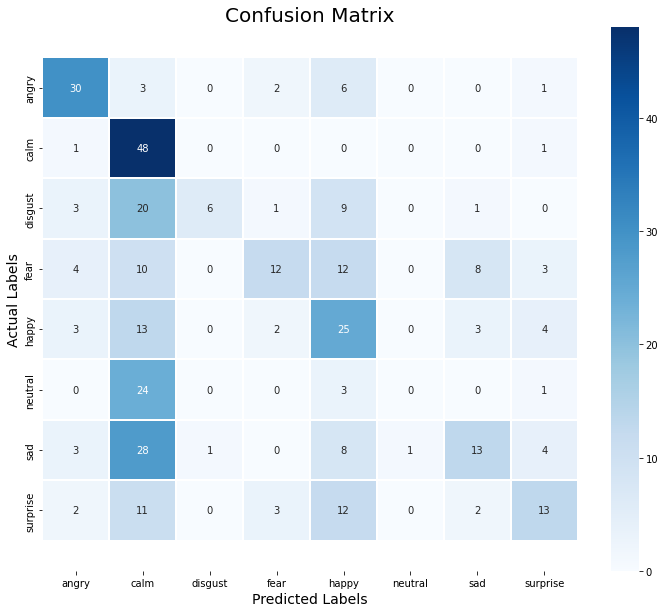

In [120]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

The MLP model has mismatched most if not all the labels with calm.

### Hyperparameter tuning of MLP

In [121]:
# Finding best parameters
from sklearn.model_selection import GridSearchCV
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, y_train) # X is train samples and y is the corresponding labels

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.01, batch_size=256,
                                     hidden_layer_sizes=(300,),
                                     learning_rate='adaptive', max_iter=500),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [122]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [123]:
print(clf.best_estimator_)

MLPClassifier(activation='tanh', alpha=0.05, batch_size=256,
              hidden_layer_sizes=(20,), max_iter=500)


In [124]:
# performance metrics
y_true, clf_predictions = y_test, clf.predict(x_test)
 
# print classification report
print(classification_report(y_test, clf_predictions))

              precision    recall  f1-score   support

       angry       0.69      0.74      0.71        42
        calm       0.40      0.50      0.45        50
     disgust       0.40      0.53      0.45        40
        fear       0.67      0.37      0.47        49
       happy       0.40      0.34      0.37        50
     neutral       0.25      0.18      0.21        28
         sad       0.39      0.40      0.39        58
   surprised       0.44      0.53      0.48        43

    accuracy                           0.45       360
   macro avg       0.46      0.45      0.44       360
weighted avg       0.46      0.45      0.45       360



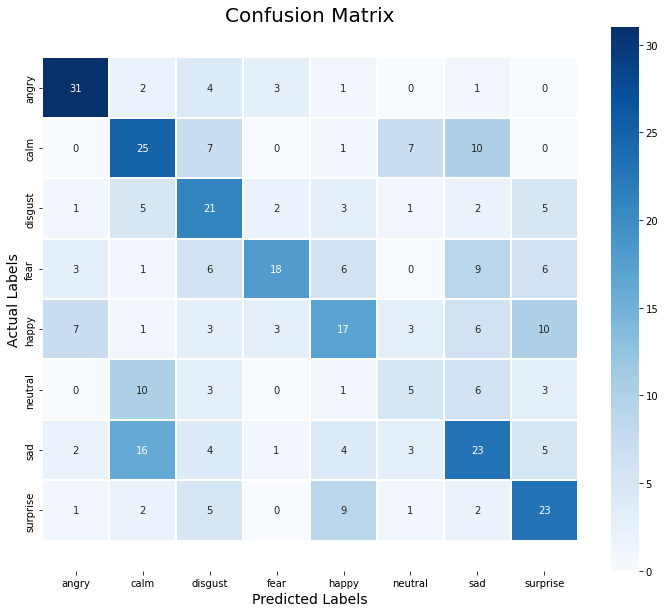

In [125]:
# confusion matrix
cm = confusion_matrix(y_test, clf_predictions)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

# Support Vector Machine Classifier

In [126]:
# function for loading data
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob('/content/drive/My Drive/Audio_Speech_Actors_01-24/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    
    return {"X":x,"y":y}

In [127]:
Trial_dict = load_data(test_size = 0.3)

In [128]:
# Training and testing data
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [129]:
X.shape, y.shape

((1440, 180), (1440, 1))

In [130]:
# column rename
y=y.rename(columns= {0: 'emotion'})

In [131]:
# concatenating the attributes and label into a single dataframe
data = pd.concat([X, y], axis =1)

In [132]:
# looking at the data
data.head()

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,emotion
0,-633.191467,73.330414,8.610302,20.852024,7.930534,11.394039,4.647690,-2.742885,-8.237446,10.198352,...,0.000079,0.000124,0.000077,0.000039,0.000031,1.236175e-05,2.919671e-06,2.149176e-07,3.751919e-08,calm
1,-649.411011,66.842705,2.792660,18.245054,9.904177,11.159477,3.498940,-0.110335,-4.559010,6.207245,...,0.000003,0.000009,0.000007,0.000004,0.000001,3.945554e-07,1.471665e-07,1.331188e-08,3.206221e-09,calm
2,-640.467224,73.684235,4.830622,28.677061,14.004562,15.550364,5.663946,-1.506477,-4.980078,10.866725,...,0.000006,0.000009,0.000007,0.000005,0.000002,9.282150e-07,1.777972e-07,3.566981e-08,4.340473e-09,calm
3,-646.565979,78.240234,5.812848,23.272985,13.461740,11.165086,6.540208,-2.067871,-7.179391,9.426168,...,0.000008,0.000009,0.000003,0.000002,0.000001,4.424094e-07,8.870213e-08,1.833787e-08,1.715404e-09,neutral
4,-650.978760,69.353516,9.970227,23.253746,11.487150,12.041039,4.189495,2.425045,-6.176125,8.289584,...,0.000009,0.000010,0.000008,0.000004,0.000002,4.943259e-07,1.268739e-07,2.722038e-08,2.614305e-09,calm


In [133]:
# shuffling data
data = data.reindex(np.random.permutation(data.index))

In [134]:
# Saving dataset
data.to_csv("/content/drive/My Drive/RAVDESS_MFCC_Observed.csv")

In [135]:
data = pd.read_csv('/content/drive/My Drive/RAVDESS_MFCC_Observed.csv')
print(data.head())

   Unnamed: 0           0          1          2          3         4  \
0  1339       -430.770630  20.122019 -56.469952 -0.581591  -7.880157   
1  21         -582.214966  60.768349 -5.702714   18.531998  7.341261   
2  964        -707.992371  48.696045 -0.360720   12.994987 -1.504996   
3  111        -562.629761  30.873121 -11.314758  5.373128  -3.777014   
4  1414       -573.594360  49.186207 -5.265389   15.504213 -3.937147   

           5          6         7          8  ...       171       172  \
0 -15.150893 -27.666035 -6.437409 -18.203716  ...  0.000079  0.000065   
1  9.699893  -1.070609  -4.268919 -7.880933   ...  0.000012  0.000010   
2  4.729754  -11.950106 -1.476917 -11.728357  ...  0.000008  0.000010   
3 -5.198400  -9.287609  -7.223110 -6.757509   ...  0.000819  0.001075   
4  1.563768  -8.442286  -3.646133 -16.220686  ...  0.000365  0.000205   

        173       174       175           176           177           178  \
0  0.000054  0.000031  0.000023  9.615951e-06  3.82

In [136]:
data.shape

(1440, 182)

In [137]:
# data columns
data.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '171', '172', '173', '174', '175', '176', '177', '178', '179',
       'emotion'],
      dtype='object', length=182)

In [138]:
# dropping column Unnamed: 0 to remove shuffled index
data = data.drop('Unnamed: 0',axis=1)

In [139]:
data.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '171', '172', '173', '174', '175', '176', '177', '178', '179',
       'emotion'],
      dtype='object', length=181)

In [140]:
# separating features and target 
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

In [141]:
X.shape, y.shape

((1440, 180), (1440,))

In [142]:
np.unique(y)

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [143]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [144]:
from sklearn.svm import SVC

svclassifier = SVC(kernel = 'linear')

In [145]:
# fitting model
svclassifier.fit(X_train, y_train)


SVC(kernel='linear')

In [146]:
# predictions
y_pred = svclassifier.predict(X_test)

              precision    recall  f1-score   support

       angry       0.63      0.63      0.63        35
        calm       0.62      0.61      0.62        33
     disgust       0.44      0.62      0.52        32
        fear       0.52      0.60      0.56        42
       happy       0.47      0.36      0.41        45
     neutral       0.31      0.31      0.31        16
         sad       0.39      0.43      0.41        35
   surprised       0.55      0.44      0.49        50

    accuracy                           0.50       288
   macro avg       0.49      0.50      0.49       288
weighted avg       0.51      0.50      0.50       288



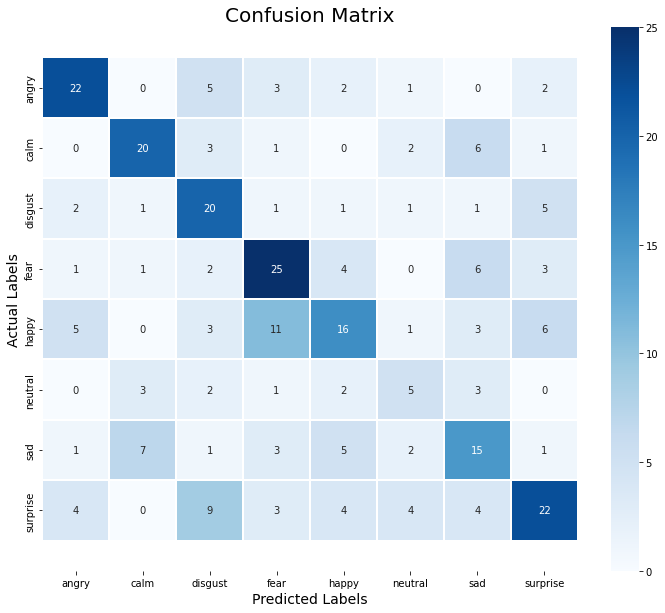

In [147]:
# performance metrics
print(classification_report(y_test,y_pred))


# plotting confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()


In [148]:
train_acc = float(svclassifier.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svclassifier.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 77.69097222222221 ----
----test accuracy score 50.34722222222222 ----


In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


#splitting dataset into train/ test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('SVM', SVC())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: svc_scaled
svc_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)

# compute metrics
print('Accuracy with Scaling: {}'.format(svc_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(svc_unscaled.score(X_test, y_test)))


Accuracy with Scaling: 0.4861111111111111
Accuracy without Scaling: 0.4722222222222222


In [151]:
train_acc = float(svc_scaled.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svc_scaled.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 60.15625 ----
----test accuracy score 48.61111111111111 ----


In [152]:
scaled_predictions = svc_scaled.predict(X_test)

              precision    recall  f1-score   support

       angry       0.70      0.46      0.56        41
        calm       0.46      0.88      0.61        34
     disgust       0.44      0.45      0.44        38
        fear       0.62      0.56      0.59        27
       happy       0.39      0.27      0.32        44
     neutral       0.00      0.00      0.00        17
         sad       0.49      0.50      0.49        44
   surprised       0.44      0.58      0.50        43

    accuracy                           0.49       288
   macro avg       0.44      0.46      0.44       288
weighted avg       0.47      0.49      0.46       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


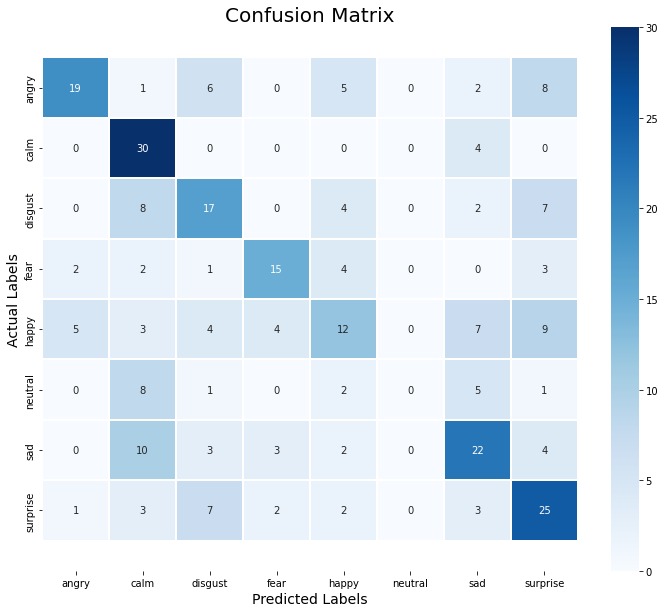

In [153]:
# performance metrics
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,scaled_predictions))


# plotting confusion matrix
cm = confusion_matrix(y_test,scaled_predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

### Hyperparameter tuning of SVM

In [155]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.143 total time=   0.2s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.143 total time=   0.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [156]:
# print best parameter
print(grid.best_params_)
 
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001)


In [157]:
grid_predictions = grid.predict(X_test)
 
# performance metrics
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

       angry       0.61      0.68      0.64        41
        calm       0.63      0.85      0.72        34
     disgust       0.55      0.45      0.49        38
        fear       0.56      0.67      0.61        27
       happy       0.55      0.55      0.55        44
     neutral       0.47      0.53      0.50        17
         sad       0.66      0.43      0.52        44
   surprised       0.56      0.53      0.55        43

    accuracy                           0.58       288
   macro avg       0.57      0.59      0.57       288
weighted avg       0.58      0.58      0.57       288



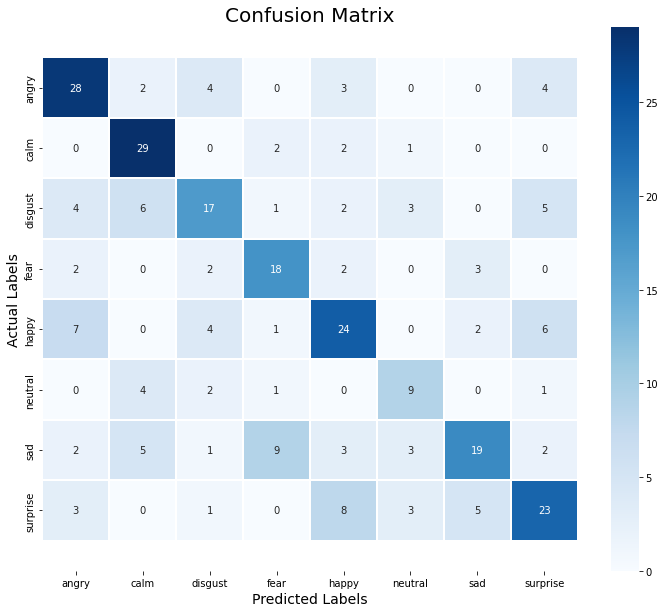

In [158]:
# plotting confusion matrix
cm = confusion_matrix(y_test,grid_predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

# Conclusion
In this project, we presented an architecture based on deep neural networks for the
classification of emotions using audio recordings from the Ryerson Audio-Visual
Database of Emotional Speech and Song (RAVDESS).The model has been trained to classify seven different emotions (neutral,
calm, happy, sad, angry, fearful, disgust, surprised) and obtained the best performances on the Angry class (0.79) and worst on the Neutral
class (0.31).The best classification has been performed by SVM and 1D-CNN Mdoel after Data Augmentation with the highest accuracy of 58%